### **The Hollywood Effect: How Actor Names Shape Baby Naming Trends**

This project explores the potential cultural influence of film media by examining whether the names of actors and characters from popular movies are associated with spikes in baby name popularity. Specifically, it investigates whether a sudden rise in the usage of a baby name correlates with its increased visibility among lead performers in film.

The analysis draws from two primary datasets:

- **U.S. Baby Name Data** (through 2014), containing annual name counts by gender  
- **IMDb Movie Data** (starting from 1912), focused on the top-billed actors and their character names

To ensure consistency and reduce noise, the data was filtered to:

- Include only **English-language films**
- Limit analysis to the **top three billed performers**
- Restrict the timeline to **1912–2014**, the period where both datasets overlap

The initial hypothesis was that increased cultural exposure of a name — either through an actor or their character — may lead to a rise in its usage among newborns. However, early exploratory findings revealed that **actor names exhibited much stronger and more consistent patterns of influence** than character names. As a result, **character names were excluded from the final modelling**, allowing the analysis to focus entirely on actor-related features.

Through a combination of descriptive analysis, spike detection, and unsupervised clustering, this study attempts to uncover hidden patterns where film culture may have quietly shaped naming trends across generations.


In [2]:
from google.colab import files
import pandas as pd

uploaded = files.upload()
import io
df = pd.read_csv(io.BytesIO(list(uploaded.values())[0]))

df.info()
# df.head()

Saving ABC01.csv to ABC01.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1617483 entries, 0 to 1617482
Data columns (total 5 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   Name                  1617483 non-null  object
 1   Year                  1617483 non-null  int64 
 2   Count_ActorNames      1617483 non-null  int64 
 3   Count_BabyNames       1617483 non-null  int64 
 4   Count_CharacterNames  1617483 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 61.7+ MB


,Name,Year,Count_ActorNames,Count_BabyNames,Count_CharacterNames
0,Osby,1912,0,7,0
1,Hilbert,1912,0,26,0
2,Foye,1912,0,6,0
3,Orbie,1912,0,7,0
4,Boleslaw,1912,0,10,0


**Exploratory Data Analysis:** Histogram of Name Counts

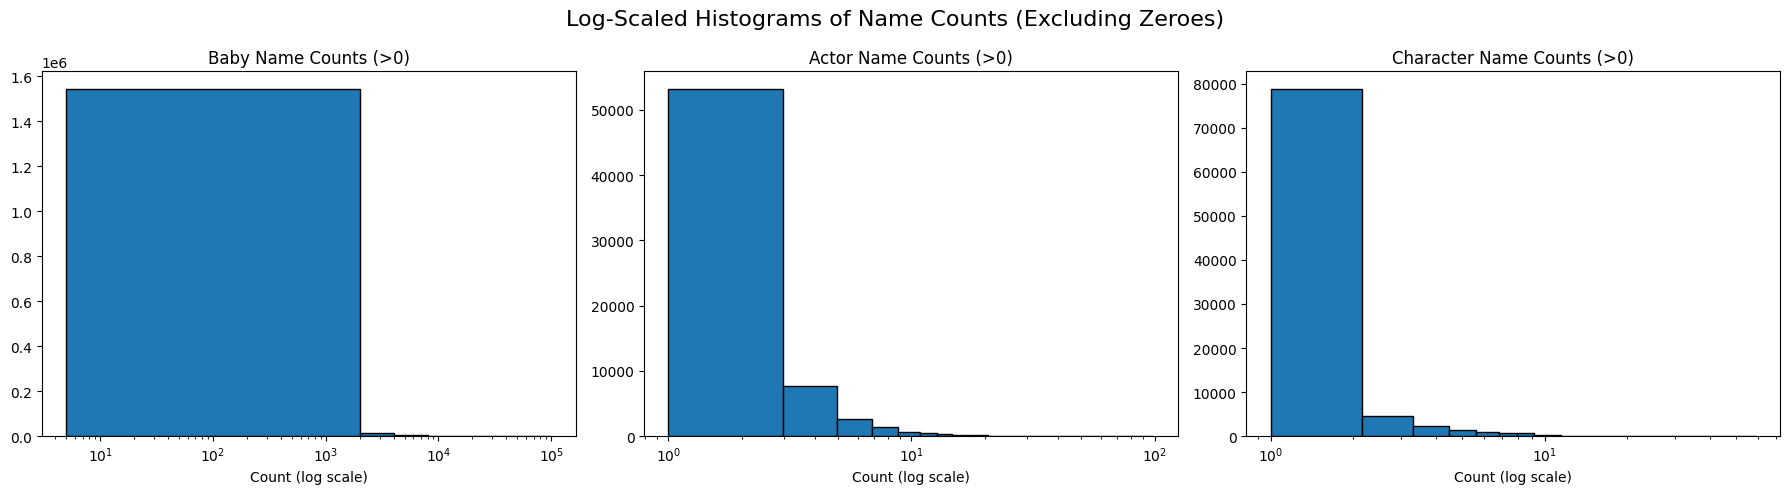

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

baby_counts = df[df['Count_BabyNames'] > 0]['Count_BabyNames']
actor_counts = df[df['Count_ActorNames'] > 0]['Count_ActorNames']
char_counts = df[df['Count_CharacterNames'] > 0]['Count_CharacterNames']

# histograms with log-scaled x-axis
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

axs[0].hist(baby_counts, bins=50, edgecolor='black')
axs[0].set_title('Baby Name Counts (>0)')
axs[0].set_xscale('log')
axs[0].set_xlabel('Count (log scale)')

axs[1].hist(actor_counts, bins=50, edgecolor='black')
axs[1].set_title('Actor Name Counts (>0)')
axs[1].set_xscale('log')
axs[1].set_xlabel('Count (log scale)')

axs[2].hist(char_counts, bins=50, edgecolor='black')
axs[2].set_title('Character Name Counts (>0)')
axs[2].set_xscale('log')
axs[2].set_xlabel('Count (log scale)')

plt.suptitle('Log-Scaled Histograms of Name Counts (Excluding Zeroes)', fontsize=16)
plt.tight_layout()
plt.show()


**Exploratory Data Analysis:** Unique Names over Time

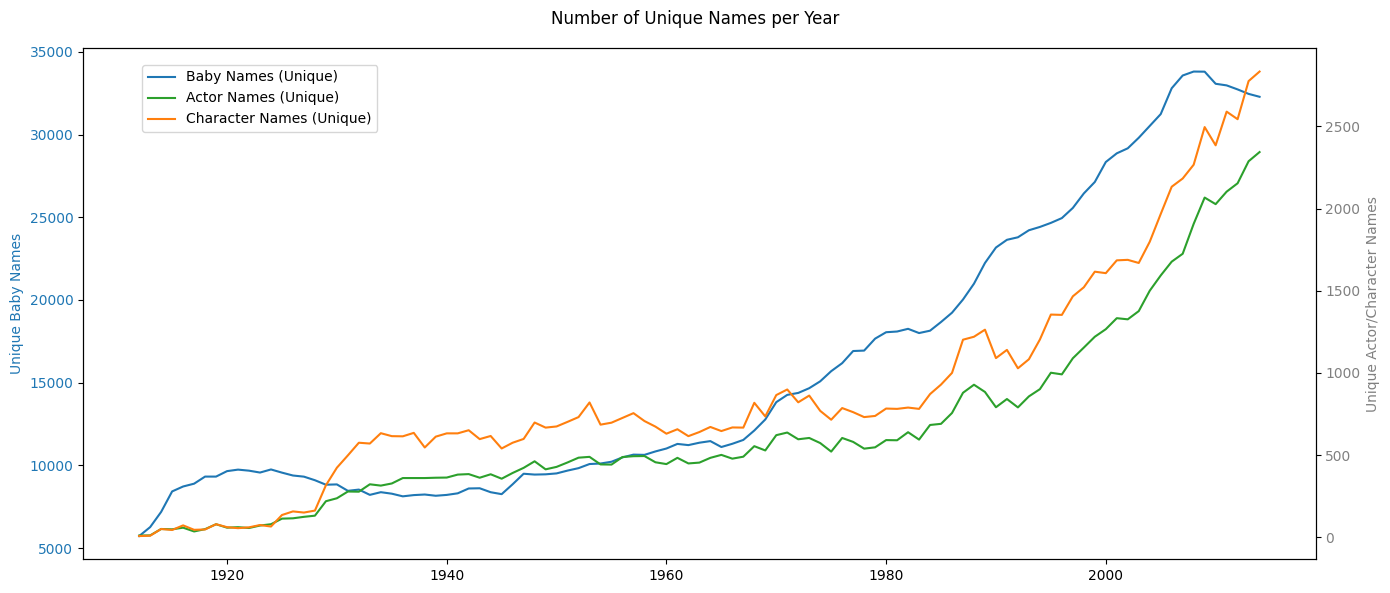

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# unique names per year
unique_names_per_year = df.groupby('Year').agg({
    'Name': lambda x: x.nunique(),  # unique names (total)
    'Count_ActorNames': lambda x: x[df['Count_ActorNames'] > 0].count(),
    'Count_CharacterNames': lambda x: x[df['Count_CharacterNames'] > 0].count()
}).rename(columns={
    'Name': 'Unique_BabyNames',
    'Count_ActorNames': 'Unique_ActorNames',
    'Count_CharacterNames': 'Unique_CharacterNames'
})

# dual Y-axis
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(unique_names_per_year.index, unique_names_per_year['Unique_BabyNames'], label='Baby Names (Unique)', color='tab:blue')
ax1.set_ylabel('Unique Baby Names', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(unique_names_per_year.index, unique_names_per_year['Unique_ActorNames'], label='Actor Names (Unique)', color='tab:green')
ax2.plot(unique_names_per_year.index, unique_names_per_year['Unique_CharacterNames'], label='Character Names (Unique)', color='tab:orange')
ax2.set_ylabel('Unique Actor/Character Names', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

fig.suptitle('Number of Unique Names per Year')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()


**Exploratory Data Analysis:** Names with High Occurences

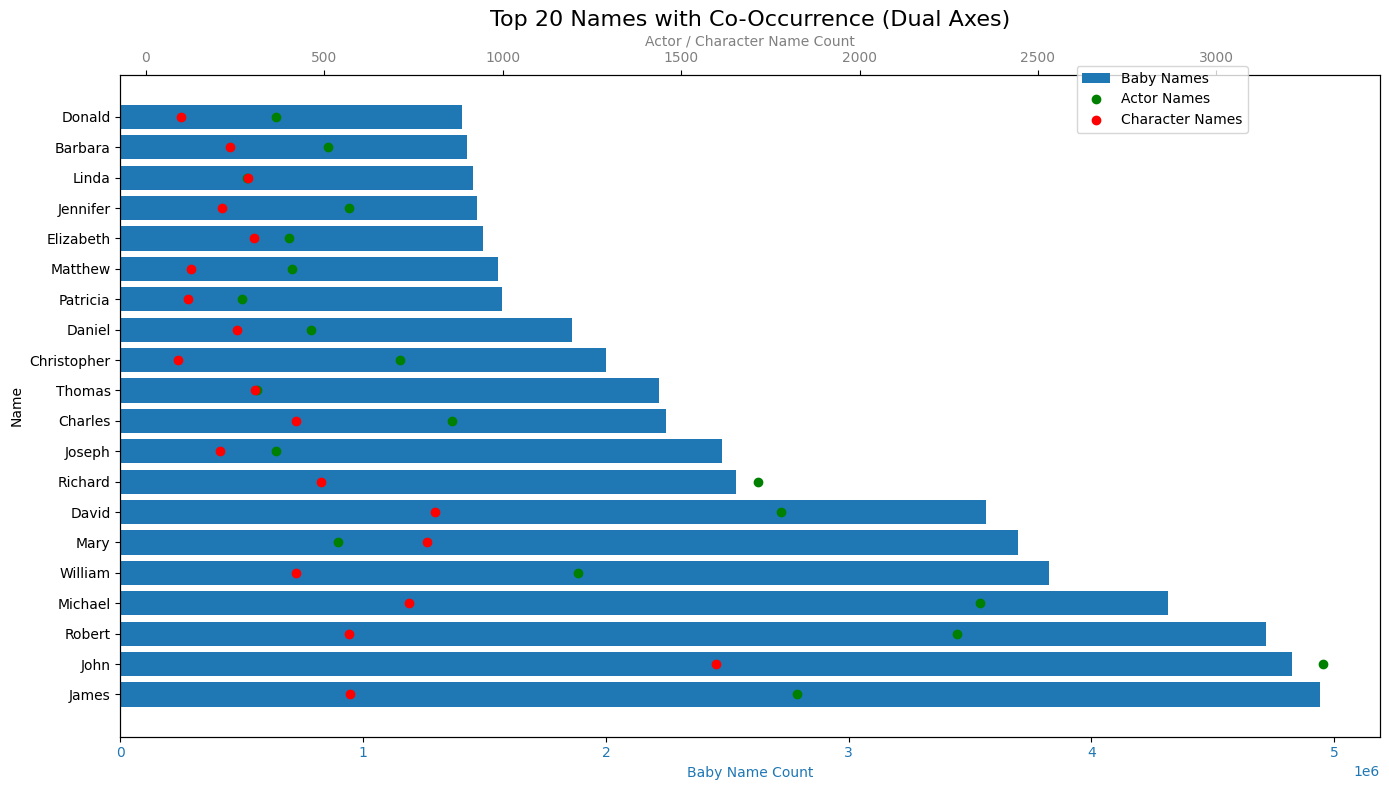

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

name_counts = df.groupby('Name')[['Count_BabyNames', 'Count_ActorNames', 'Count_CharacterNames']].sum()

co_occurring = name_counts[
    (name_counts['Count_BabyNames'] > 0) &
    (name_counts['Count_ActorNames'] > 0) &
    (name_counts['Count_CharacterNames'] > 0)
].copy()

co_occurring['Total'] = co_occurring.sum(axis=1)

# top 20 names
top_names = co_occurring.sort_values(by='Total', ascending=False).head(20)

# twin Y-axes
fig, ax1 = plt.subplots(figsize=(14, 8))

names = top_names.index
x = range(len(names))

ax1.barh(x, top_names['Count_BabyNames'], color='tab:blue', label='Baby Names')
ax1.set_xlabel('Baby Name Count', color='tab:blue')
ax1.set_ylabel('Name')
ax1.set_yticks(x)
ax1.set_yticklabels(names)
ax1.tick_params(axis='x', labelcolor='tab:blue')

ax2 = ax1.twiny()
ax2.plot(top_names['Count_ActorNames'], x, 'go', label='Actor Names')
ax2.plot(top_names['Count_CharacterNames'], x, 'ro', label='Character Names')
ax2.set_xlabel('Actor / Character Name Count', color='gray')
ax2.tick_params(axis='x', labelcolor='gray')

plt.title('Top 20 Names with Co-Occurrence (Dual Axes)', fontsize=16)
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.92))
plt.tight_layout()
plt.show()


**Feature Engineering**

To identify sudden increases in baby name popularity, the following features were created:

- **Freq**: Normalised frequency of each name within its year (i.e., name count divided by total births that year)
- **SpikePct**: Year-over-year percentage change in *Freq*
- **Count_Diff**: Absolute year-over-year difference in baby name counts
- **Is_Baby_Spike**: A binary flag marking potential spikes in popularity. A name is flagged if: SpikePct > 20% and Count_Diff > 600
- **log_baby**: A log-transformed version of the baby name count, created to help normalise the distribution. While considered for clustering, it was ultimately excluded to preserve the unsupervised focus on actor visibility patterns.

- **Spike_Type**: Categorises spikes into:
  - *Steep Spike*: SpikePct > 45% and Count_Diff > 1000
  - *Regular Spike*: SpikePct > 20% and Count_Diff > 600
  - *No Spike*: Does not meet either threshold


In [3]:
import numpy as np
import pandas as pd

def add_baby_spike_features(df):
    data = df.copy()

    # Compute total births and normalised frequency
    data['Total_Births'] = data.groupby('Year')['Count_BabyNames'].transform('sum')
    data['Freq'] = data['Count_BabyNames'] / data['Total_Births']

    # Sort for correct time series diff
    data = data.sort_values(['Name', 'Year'])

    # Year-over-year changes
    data['SpikePct'] = data.groupby('Name')['Freq'].pct_change() * 100
    data['Count_Diff'] = data.groupby('Name')['Count_BabyNames'].diff()

    # Binary spike flag
    data['Is_Baby_Spike'] = (data['SpikePct'] > 20) & (data['Count_Diff'] > 600)

    # Spike type categorisation
    conditions = [
        (data['SpikePct'] > 45) & (data['Count_Diff'] > 1000),
        (data['SpikePct'] > 20) & (data['Count_Diff'] > 600)
    ]
    choices = ['steep spike', 'regular spike']
    data['Spike_Type'] = np.select(conditions, choices, default='no spike')

    # Log-transformed baby name count
    data['log_baby'] = np.log1p(data['Count_BabyNames'])  # log(1 + count) to handle 0s safely

    return data

baby_df = add_baby_spike_features(df)


**EDA:** Frequency Distribution of Spike Types

In [4]:
baby_df['Is_Baby_Spike'].value_counts()
baby_df['Spike_Type'].value_counts()

,count
Spike_Type,
no spike,1615650
regular spike,1407
steep spike,426


**EDA:** Top Names with Highest Spikes

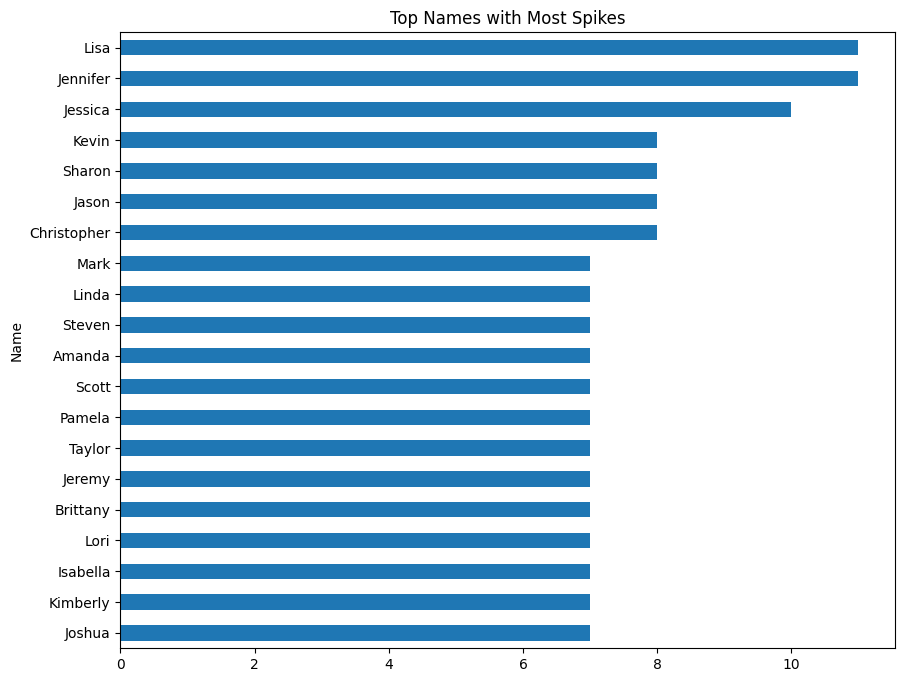

In [16]:
top_spikes = baby_df[baby_df['Is_Baby_Spike']].groupby('Name')['Is_Baby_Spike'].sum()
top_spikes.sort_values(ascending=False).head(20).plot(kind='barh', figsize=(10, 8), title='Top Names with Most Spikes')
plt.gca().invert_yaxis()
plt.show()


**EDA:** Trend based on a specific baby name

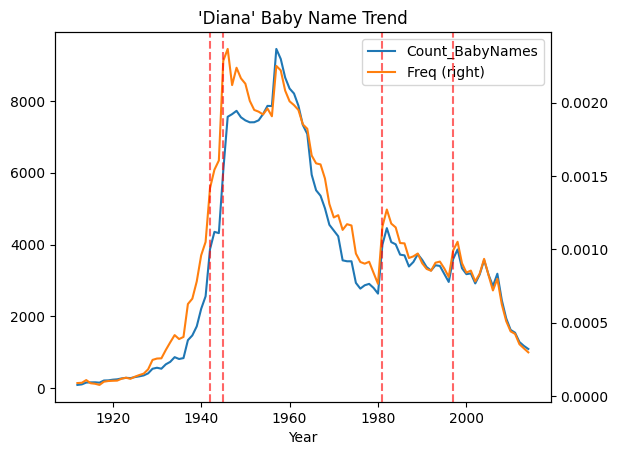

In [19]:
name = 'Diana'
subset = baby_df[baby_df['Name'] == name]

subset.plot(x='Year', y=['Count_BabyNames', 'Freq'], secondary_y='Freq', title=f"'{name}' Baby Name Trend")

spike_years = subset[subset['Is_Baby_Spike']]['Year']
for y in spike_years:
    plt.axvline(x=y, color='red', linestyle='--', alpha=0.6)


**EDA:** Features based on a specific baby name

In [20]:
baby_df[
    (baby_df['Name'] == 'Deanna') &
    (baby_df['Year'] >= 1925) &
    (baby_df['Year'] <= 1950)
]

,Name,Year,Count_ActorNames,Count_BabyNames,Count_CharacterNames,log_baby,log_actor,log_char,Total_Births,Freq,SpikePct,Count_Diff,Is_Baby_Spike,Spike_Type
120983,Deanna,1925,0,10,0,2.397895,0.000000,0.0,2333310,0.000004,-48.964625,-10.0,False,no spike
130376,Deanna,1926,0,16,0,2.833213,0.000000,0.0,2295809,0.000007,62.613528,6.0,False,no spike
139709,Deanna,1927,0,16,0,2.833213,0.000000,0.0,2319047,0.000007,-1.002050,0.0,False,no spike
148818,Deanna,1928,0,8,0,2.197225,0.000000,0.0,2260635,0.000004,-48.708062,-8.0,False,no spike
157629,Deanna,1929,0,11,0,2.484907,0.000000,0.0,2191735,0.000005,41.822489,3.0,False,no spike
166491,Deanna,1930,0,7,0,2.079442,0.000000,0.0,2222937,0.000003,-37.256861,-4.0,False,no spike
174956,Deanna,1931,0,10,0,2.397895,0.000000,0.0,2103624,0.000005,50.959691,3.0,False,no spike
183485,Deanna,1932,0,6,0,1.945910,0.000000,0.0,2110802,0.000003,-40.204036,-4.0,False,no spike
191737,Deanna,1933,0,13,0,2.639057,0.000000,0.0,1998837,0.000007,128.803266,7.0,False,no spike
200111,Deanna,1934,0,15,0,2.772589,0.000000,0.0,2076330,0.000007,11.078219,2.0,False,no spike


**Feature Engineering**

To detect the cultural emergence and sustained popularity of actor names, the following features were engineered:

- **Actor_Rate**: Proportional share of a name among all actor name mentions in that year
- **Actor_Rise**: Boolean flag marking a 'rise' year — the first in a run of 3+ consecutive non-zero years following at least 10 years of absence
- **Actor_Sustained**: Indicates whether the name maintained its actor visibility from the previous year (either stable or a ≤30% drop)

In addition to these core features, we also created **lagged versions** of key signals to support temporal analysis:

- **Actor_Rate_Lag1, Lag2, Lag3**: The actor rate for 1, 2, and 3 years prior
- **Actor_Rise_Lag1, Lag2, Lag3**: Whether an actor rise occurred 1, 2, or 3 years prior

These features are designed to capture the **initial visibility**, **delayed influence**, and **continued relevance** of names in film media, forming the basis for later testing whether actor trends precede spikes in baby name usage.

In [21]:
import numpy as np

def compute_actor_rise(counts, gap=10, run=3):
    counts = np.asarray(counts)
    rise = np.zeros(len(counts), dtype=bool)
    for i in range(len(counts)):
        if counts[i] > 0 and i >= gap and np.all(counts[i-gap:i] == 0):
            if i + run <= len(counts) and np.all(counts[i:i+run] > 0):
                rise[i] = True
    return rise

def add_actor_features(df, gap=10, run=3):
    data = df.copy()
    data = data.sort_values(['Name', 'Year']).reset_index(drop=True)

    # 1. Normalised actor rate
    data['Total_Actors'] = data.groupby('Year')['Count_ActorNames'].transform('sum')
    data['Actor_Rate'] = data['Count_ActorNames'] / data['Total_Actors']

    # 2. Actor rise detection
    data['Actor_Rise'] = data.groupby('Name')['Count_ActorNames'].transform(
        lambda cnt: compute_actor_rise(cnt.values, gap=gap, run=run)
    )

    # 3. Actor sustained signal
    prev_counts = data.groupby('Name')['Count_ActorNames'].shift(1)
    data['Actor_Sustained'] = (
        (data['Count_ActorNames'] > 0) &
        (
            (data['Count_ActorNames'] >= prev_counts) |
            (((prev_counts - data['Count_ActorNames']) / prev_counts) <= 0.3)
        )
    )

    # 4. Lagged features
    for lag in range(1, 4):
        data[f'Actor_Rate_Lag{lag}'] = data.groupby('Name')['Actor_Rate'].shift(lag)
        data[f'Actor_Rise_Lag{lag}'] = data.groupby('Name')['Actor_Rise'].shift(lag)

    return data

actor_df = add_actor_features(df)


**EDA:** Actor Rise Events per Year

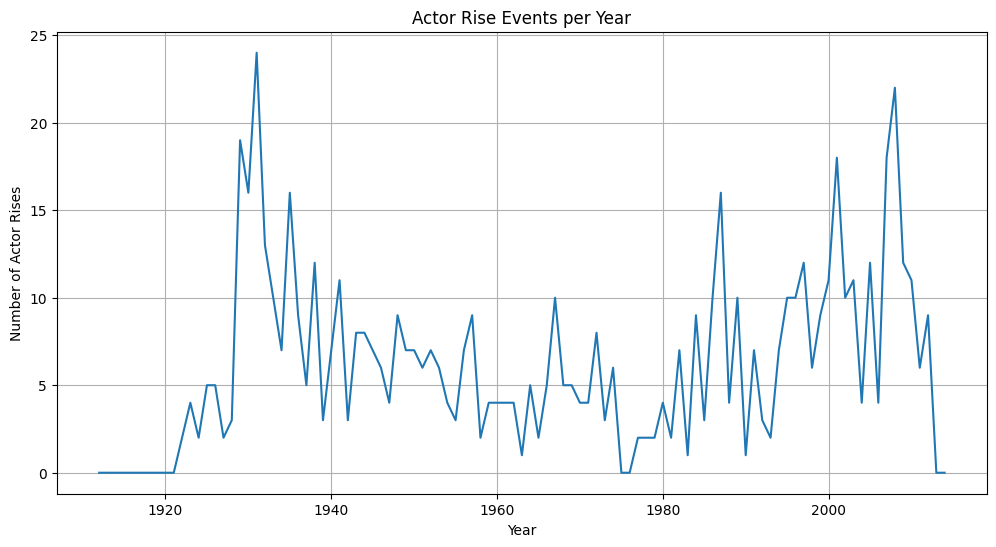

In [22]:
actor_df.groupby('Year')['Actor_Rise'].sum().plot(
    figsize=(12,6), title='Actor Rise Events per Year'
)
plt.ylabel('Number of Actor Rises')
plt.grid(True)
plt.show()


**EDA:** Names with Most Actor Rise Events

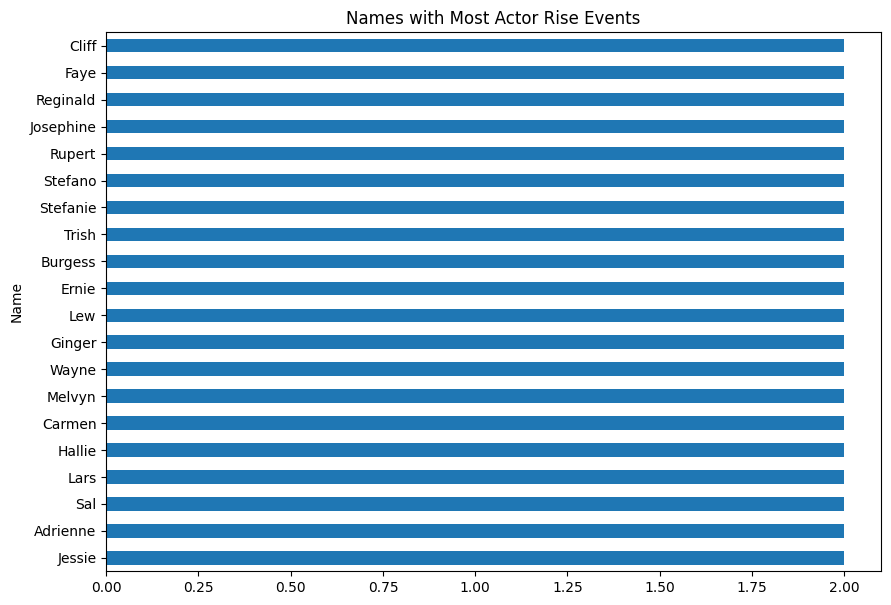

In [23]:
actor_df[actor_df['Actor_Rise']].groupby('Name')['Actor_Rise'].sum().sort_values(ascending=False).head(20).plot(
    kind='barh', figsize=(10,7), title='Names with Most Actor Rise Events'
)
plt.gca().invert_yaxis()
plt.show()


**EDA:** Actor Mentions based on a specific name

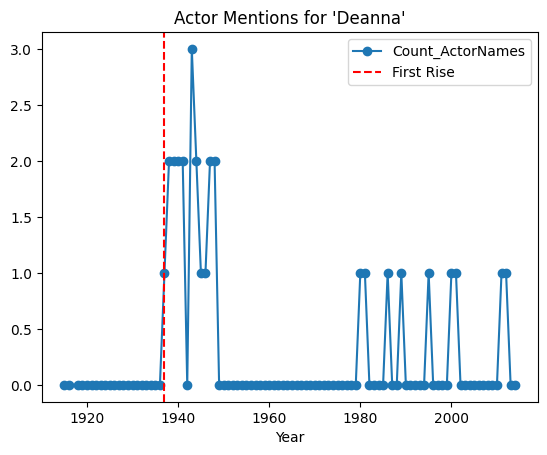

In [25]:
name = 'Deanna'
subset = actor_df[actor_df['Name'] == name]

subset.plot(x='Year', y='Count_ActorNames', marker='o', title=f"Actor Mentions for '{name}'")
plt.axvline(x=subset[subset['Actor_Rise']].Year.min(), color='red', linestyle='--', label='First Rise')
plt.legend()
plt.show()


**EDA:** Actor Features based on a specific name

In [26]:
actor_df[
    (actor_df['Name'] == 'Deanna') &
    (actor_df['Year'] >= 1925) &
    (actor_df['Year'] <= 1945)
]

,Name,Year,Count_ActorNames,Count_BabyNames,Count_CharacterNames,log_baby,log_actor,log_char,Total_Actors,Actor_Rate,Actor_Rise,Actor_Sustained
370440,Deanna,1925,0,10,0,2.397895,0.000000,0.0,160,0.000000,False,False
370441,Deanna,1926,0,16,0,2.833213,0.000000,0.0,185,0.000000,False,False
370442,Deanna,1927,0,16,0,2.833213,0.000000,0.0,190,0.000000,False,False
370443,Deanna,1928,0,8,0,2.197225,0.000000,0.0,198,0.000000,False,False
370444,Deanna,1929,0,11,0,2.484907,0.000000,0.0,435,0.000000,False,False
370445,Deanna,1930,0,7,0,2.079442,0.000000,0.0,595,0.000000,False,False
370446,Deanna,1931,0,10,0,2.397895,0.000000,0.0,766,0.000000,False,False
370447,Deanna,1932,0,6,0,1.945910,0.000000,0.0,889,0.000000,False,False
370448,Deanna,1933,0,13,0,2.639057,0.000000,0.0,920,0.000000,False,False
370449,Deanna,1934,0,15,0,2.772589,0.000000,0.0,996,0.000000,False,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1617483 entries, 0 to 1617482
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Name                  1617483 non-null  object 
 1   Year                  1617483 non-null  int64  
 2   Count_ActorNames      1617483 non-null  int64  
 3   Count_BabyNames       1617483 non-null  int64  
 4   Count_CharacterNames  1617483 non-null  int64  
 5   Total_Births          1617483 non-null  int64  
 6   Freq                  1617483 non-null  float64
 7   SpikePct              1489957 non-null  float64
 8   Count_Diff            1506650 non-null  float64
 9   Is_Baby_Spike         1617483 non-null  bool   
 10  Spike_Type            1617483 non-null  object 
 11  log_baby              1617483 non-null  float64
 12  Actor_Rate            1617483 non-null  float64
 13  Actor_Rise            1617483 non-null  bool   
 14  Actor_Sustained       1617483 non-

### Clustering Based on Actor Visibility Patterns

In this step, we apply KMeans clustering to group baby names based on patterns of actor visibility over time. The model uses:

- **Actor_Rate**: how frequently a name appears among credited actors in a given year  
- **Lagged Actor_Rate values**: the name's actor prominence in the previous three years  
- **Actor_Rise**: a flag indicating whether the name reappeared in media after a long absence  

These features were selected to reflect **cultural presence and visibility** in film, without referencing actual baby name trends. Missing values in lagged features were imputed as zero, and all variables were standardised prior to clustering.

We initially considered including other features such as **log-transformed baby name counts (`log_baby`)**, but found they offered little additional insight and risked introducing outcome bias into the clustering process. These were excluded to preserve the unsupervised nature of the model.

Importantly, the clustering is entirely **unsupervised** — it does not use any baby name data (spikes or frequencies) to form the groups. After clustering, we interpret the results using **external outcome labels**:

- **Is_Baby_Spike**: a binary flag for significant surges in baby name usage  
- **Spike_Type**: a categorical label distinguishing steep, regular, or no spike events  

These post-clustering metrics act as **validation signals**, helping us evaluate whether certain actor-driven clusters align more closely with real-world spikes in naming trends.


In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd


combined_df = baby_df.merge(
    actor_df[['Name', 'Year', 'Actor_Rate', 'Actor_Rise', 'Actor_Sustained', 'Actor_Rate_Lag1', 'Actor_Rate_Lag2', 'Actor_Rate_Lag3', 'Actor_Rise_Lag1', 'Actor_Rise_Lag2', 'Actor_Rise_Lag3']],
    on=['Name', 'Year'],
    how='outer'
)

clustering_features = [
    'Actor_Rate',
    'Actor_Rate_Lag1', 'Actor_Rate_Lag2', 'Actor_Rate_Lag3',
    'Actor_Rise'
]

cluster_df = combined_df[clustering_features].copy()
cluster_df = cluster_df.fillna(0)

scaler = StandardScaler()
X_cluster = scaler.fit_transform(cluster_df)

# KMeans clustering
n_clusters = 3
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
combined_df['Actor_Influence_Cluster'] = kmeans_model.fit_predict(X_cluster)

cluster_profile = (
    combined_df
    .groupby('Actor_Influence_Cluster')[
        clustering_features  # just the ones actually used
    ]
    .mean()
    .round(4)
)


# Average spike rate per cluster
spike_rate_by_cluster = (
    combined_df
    .groupby('Actor_Influence_Cluster')['Is_Baby_Spike']
    .mean()
    .rename('Spike_Rate')
)
cluster_profile = cluster_profile.join(spike_rate_by_cluster)

cluster_counts = (
    combined_df['Actor_Influence_Cluster']
    .value_counts()
    .sort_index()
    .rename('Num_Entries')
)
cluster_profile = cluster_profile.join(cluster_counts)

print("\nCluster Interpretation Summary:")
display(cluster_profile)

# Count per cluster

ct_counts = pd.crosstab(
    combined_df['Actor_Influence_Cluster'],
    combined_df['Spike_Type'],
    rownames=['Actor_Cluster'],
    colnames=['Spike_Type']
)
print("Counts of spike types by actor cluster:")
display(ct_counts)



Cluster Interpretation Summary:


,Actor_Rate,Actor_Rate_Lag1,Actor_Rate_Lag2,Actor_Rate_Lag3,Actor_Rise,Spike_Rate,Num_Entries
Actor_Influence_Cluster,,,,,,,
0,0.0000,0.0000,0.0001,0.0001,0.0,0.001115,1614825
1,0.0126,0.0132,0.0134,0.0132,0.0,0.009411,2019
2,0.0014,0.0000,0.0000,0.0000,1.0,0.020344,639


Counts of spike types by actor cluster:


Spike_Type,no spike,regular spike,steep spike
Actor_Cluster,,,
0,1613024,1387,414
1,2000,13,6
2,626,7,6


### Most Likely Media-Driven Name Spikes

This section highlights the names that most strongly align with our original hypothesis:  
**cases where actor visibility may have contributed to a sudden surge in baby name usage.**

While the clustering model was built solely on actor-related features, we now evaluate the results against real-world name trends to identify the most compelling examples of potential media influence.

To do this, we filtered for names that:
- Belong to **Cluster 1 or Cluster 2**, which reflect moderate to high actor visibility patterns
- Experienced a **steep spike** in baby name counts (`Spike_Type == 'steep spike'`)
- Were flagged by our `Is_Baby_Spike` indicator as showing statistically significant growth

This subset represents the **strongest candidates** for culturally driven name spikes — names that surged in popularity around the same time they appeared in film or media. While this doesn't confirm causation, the alignment between actor trends and naming behaviour in these cases is too striking to dismiss.

The table below lists these names alongside their corresponding years and media-related features.


In [25]:
# Filter for spike events in clusters 1 and 2
spike_clusters_1_2_df = combined_df[
    (combined_df['Is_Baby_Spike'] == True)
    & (combined_df['Actor_Influence_Cluster'].isin([1,2]))
    & (combined_df['Spike_Type'] == 'steep spike')
]

# Select key fields and sort for readability
result_df = (
    spike_clusters_1_2_df[['Actor_Influence_Cluster', 'Name', 'Year', 'Count_BabyNames', 'Actor_Rate', 'Actor_Rate_Lag1', 'Actor_Rise', 'Spike_Type', 'Actor_Sustained' ]]
    .sort_values(by=['Actor_Influence_Cluster', 'Year'])
)

# Display the list
import pandas as pd
pd.set_option('display.max_rows', 50)  # adjust if needed
display(result_df)


,Actor_Influence_Cluster,Name,Year,Count_BabyNames,Actor_Rate,Actor_Rate_Lag1,Actor_Rise,Spike_Type,Actor_Sustained
573918,1,Gloria,1921,2737,0.000000,0.014085,False,steep spike,False
573919,1,Gloria,1922,4510,0.014925,0.000000,False,steep spike,True
573922,1,Gloria,1925,9402,0.006250,0.010989,False,steep spike,True
417625,1,Dolores,1928,9663,0.010101,0.010526,False,steep spike,True
736173,1,Joan,1929,11719,0.009195,0.015152,False,steep spike,True
708540,1,Jeff,1957,4099,0.008084,0.007719,False,steep spike,True
370452,2,Deanna,1937,1631,0.000950,0.000000,True,steep spike,True
198161,2,Brenda,1939,2775,0.001894,0.000000,True,steep spike,True
200438,2,Brett,1958,2157,0.002660,0.000000,True,steep spike,True
1510841,2,Troy,1961,4381,0.002112,0.000000,True,steep spike,True


### From Patterns to Possibilities

As we’ve seen, several names in this filtered subset not only spiked in baby name usage but also showed strong alignment with media presence — either through sudden actor visibility or reappearance in film credits. These aren't just statistical outliers; they reflect the way cultural moments and media icons leave imprints on personal choices like naming a child.

Still, it’s worth noting that not all name spikes fit this pattern. Names like *Diana*, for instance, spiked dramatically but fell outside the actor-based clusters — a reminder that influence can come from beyond the screen: royalty, politics, or even religious and social movements.

With these nuances in mind, we now return to the broader takeaway from this project. Code below shows clustered data set focusing on a single name and year, plus/minus ten years.

In [26]:
# Set variables
target_name = 'Brett'
target_year = 1958

window_df = combined_df[
    (combined_df['Name'] == target_name) &
    (combined_df['Year'] >= target_year - 10) &
    (combined_df['Year'] <= target_year + 10)
].copy()

inspection_cols = [
    'Actor_Influence_Cluster', 'Name', 'Year',
    'Count_BabyNames', 'Actor_Rate', 'Actor_Rate_Lag1',
    'Actor_Rise', 'Is_Baby_Spike', 'Spike_Type', 'Count_ActorNames', 'Actor_Sustained'
]

window_df = window_df[inspection_cols].sort_values('Year')

import pandas as pd
pd.set_option('display.max_rows', 25)
display(window_df)


,Actor_Influence_Cluster,Name,Year,Count_BabyNames,Actor_Rate,Actor_Rate_Lag1,Actor_Rise,Is_Baby_Spike,Spike_Type,Count_ActorNames,Actor_Sustained
200428,0,Brett,1948,140,0.000000,0.000000,False,False,no spike,0,False
200429,0,Brett,1949,140,0.000000,0.000000,False,False,no spike,0,False
200430,0,Brett,1950,223,0.000000,0.000000,False,False,no spike,0,False
200431,0,Brett,1951,230,0.000000,0.000000,False,False,no spike,0,False
200432,0,Brett,1952,263,0.000000,0.000000,False,False,no spike,0,False
200433,0,Brett,1953,272,0.000000,0.000000,False,False,no spike,0,False
200434,0,Brett,1954,436,0.000000,0.000000,False,False,no spike,0,False
200435,0,Brett,1955,473,0.000000,0.000000,False,False,no spike,0,False
200436,0,Brett,1956,400,0.000000,0.000000,False,False,no spike,0,False
200437,0,Brett,1957,671,0.000000,0.000000,False,False,no spike,0,False


**Event-Centred Chart**

Visualisation on a single name and year, plus/minus ten years

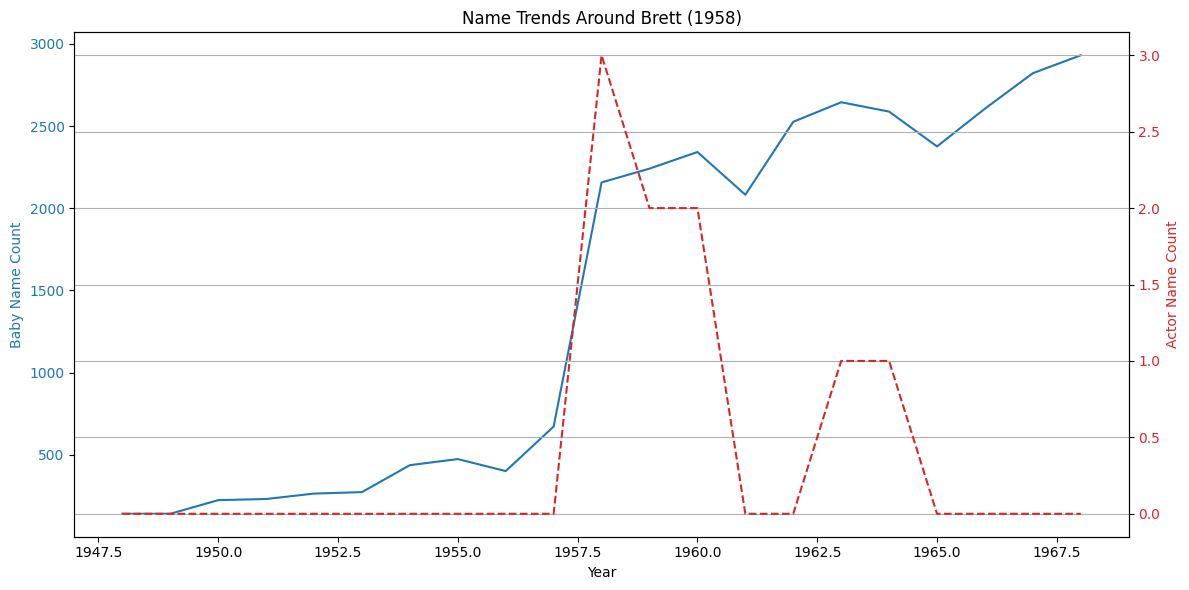

In [27]:
import matplotlib.pyplot as plt

target_name = 'Brett'
target_year = 1958

window_df = combined_df[
    (combined_df['Name'] == target_name) &
    (combined_df['Year'] >= target_year - 10) &
    (combined_df['Year'] <= target_year + 10)
].copy()

# dual Y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

color1 = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Baby Name Count', color=color1)
ax1.plot(window_df['Year'], window_df['Count_BabyNames'], color=color1, label='Baby Name Count')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Actor Name Count', color=color2)
ax2.plot(window_df['Year'], window_df['Count_ActorNames'], color=color2, linestyle='--', label='Actor Name Count')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title(f"Name Trends Around {target_name} ({target_year})")
fig.tight_layout()
plt.grid(True)
plt.show()


### **Conclusion: What Names Can Tell Us**

This project began with a simple observation — that my two best friends, both named Diana, were born in 1981, the same year Princess Diana’s wedding captivated the world. That spark of curiosity led to a data-driven journey through baby name records and media trends, culminating in an unsupervised clustering model designed to detect patterns of cultural influence.

By clustering names based solely on actor visibility over time — without referencing baby name trends — we were able to isolate groups where surges in naming appeared to align with media-driven exposure. Post-clustering analysis using spike indicators revealed that some clusters were indeed more likely to contain names with dramatic, real-world popularity spikes.

While this analysis doesn’t claim definitive causation, some of the name spikes are remarkably aligned with media events or actor visibility. These aren’t just soft trends — they are sharp, time-specific surges that strongly suggest cultural influence.

Of course, correlation does not always imply causation. But when a name like *Deanna* rises dramatically within a year of a young star’s breakout role, or *Miley* spikes exactly when *Hannah Montana* dominates pop culture, the line between correlation and causation becomes very thin.

Not all spikes fit this pattern — and that’s important too. Names like *Diana* remind us that cultural influence extends beyond film: from royalty and politics to broader social movements and public moments.

At its heart, this project is about memory, media, and meaning. It shows us that the names we carry are often reflections of the stories playing out around us — echoes of who we admired, what we watched, and how the world was changing at the time. Even something as personal as a name can leave a data trail that tells us something about culture, influence, and how we remember.
